# Constants

In [1]:
# Importing the required packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
# Constants related to gene expression data 

# Location of the preprocessed datasets
FILEPATH_PREPROCESSED = '../Data_Preprocessed/'

# Dictionary of datasets, with names attributed to them as keys
NAMES_DATASETS = {
    'FT_OD' : 'FT_OD_final_stats.csv', # Preprocessed test fluorescence normalised by growth
    'FC_OD' : 'FC_OD_final_stats.csv', # Preprocessed control fluorescence normalised by growth
    'FT_FC' : 'FT_FC_final_stats.csv'  # Preprocessed test fluorescence normalised by control fluorescence
}

In [3]:
# Constants about the sequence data 

# Location of the sequence datasets
FILEPATH_SEQ = '../Sequences/'

# Name of the distances dataset
NAME_SEQ_DATASET = 'Distances.csv'

# Smallest distance between the beginning of a promoter and its -10 element (including alignment spaces).
ELEMENT_SHIFT = 82

# For Fig S2C:
    # Name of the promoter sequence dataset
NAME_PRO_DATASET = 'Promoters.csv'
    # Location along the sequence and size of the discriminator
DISCRI_POSITION = 76
DISCRI_SIZE     = 6

In [4]:
# Constant about plotting 

OVERALL_SCALE = 4 # Scale of the plot and the appearence parameters

# Data processing

## Functions

### Functions processing gene expression data

In [5]:
# Function to load datasets 

def func_load_data(Filepath_Data_PreProcessed:str, Names_datasets:dict) -> dict:
    
    """
    Parameters:
    Filepath_Data_PreProcessed (str): The path where raw data files are located.
    Names_datasets (dict): A dictionary containing the names of the data files to be loaded.
    
    Returns:
    dict: A dictionary with the names of the datasets as keys and the loaded data as values.
    """
    
    loaded_data = {
        key: pd.read_csv(Filepath_Data_PreProcessed + value, index_col=0)
        for key, value in Names_datasets.items()}
    
    return loaded_data

In [6]:
# Function to filter data 

def func_filter_data(df, contains, not_contains=[], contains_any=[]):
    
    """
    Purpose:
    This function allows to select which samples are plotted in which figure.

    Parameters:
    - df: dataframe of interest.
        e.g. 'FT_OD' means we are interested in the fluorescence of the test gene ((dF/dt)/(dN/dt)).
    - contains: string of the condition of interest.
        e.g. 'uEdA' means we are interested in the constructs having the upstream sequence "uE" and the downstream sequence "dA".
    - not_contains: list of strings of the sub-conditions we want to avoid including.
        e.g. ['p01','p08'] means we do not want to include the constructs bearing the p01 and p08 promoters.
    - contains_any: list of strings of the sub-conditions we want to be restrained to.
        e.g. ['p04','p10'] means we only want to include the constructs bearing the p04 and p10 promoters.
        
    In other words:
        - 'not_contains' applies a NOT operation to 'contains'.
        - 'contains_any' applies an AND operation to 'contains'.

    Output:
    The function returns a filtered dataframe.
    """
     
    # select rows where the index contains the contains string
    mask = df.index.str.contains(contains)
    for nc in not_contains:
        # the mask is updated to exclude rows where the index contains nc
        mask &= ~df.index.str.contains(nc)
    
    if contains_any:
        # a new mask is created to select rows where the index contains at least one of the strings in contains_any
        contains_any_mask = df.index.str.contains('|'.join(list(map(str, contains_any))))
        # this mask is then combined with the existing mask
        mask &= contains_any_mask
        
    return df[mask] # the mask is applied to the dataframe

In [7]:
# Function to compute errors 

def func_errors(
    Numerator_Mean,
    Numerator_SEM,
    Denominator_Mean,
    Denominator_SEM
):
    """
    Purpose:
    Calculate the error associated with a ratio of two quantities.

    Parameters:
    - Numerator_Mean (float): Mean value of the numerator quantity.
    - Numerator_SEM (float): Standard error of the numerator quantity.
    - Denominator_Mean (float): Mean value of the denominator quantity.
    - Denominator_SEM (float): Standard error of the denominator quantity.

    Returns:
    - float: The calculated error or uncertainty of the ratio.
    """
    
    err = np.sqrt((Numerator_SEM/Numerator_Mean)**2 \
          + (Denominator_SEM/Denominator_Mean)**2) \
          * (Numerator_Mean/Denominator_Mean) \
    
    return err

In [8]:
# Function normalize by a factor 

def func_normalize_by_factor( signal, normalizer ):
    
    """
    Purpose:
    This function normalises a dataset (both the signal and its associated error) by a number.
    
    Parameters:
    - signal (dataframe): values to be normalized.
    - normalizer (float): value to normalize by.
    
    Return:
    Normalised dataframe (with the preserved indices).
    """
    
    signals_normalized = ( signal['Mean'] / normalizer ).tolist()
    errors_normalized  = ( signal['SEM'] / normalizer ).tolist()
    index_names = signal.index.tolist()
    
    # Create a DataFrame
    normalized_data = pd.DataFrame({'Signal': signals_normalized, 'Error': errors_normalized}, index=index_names)
    
    return normalized_data

In [9]:
# Function to normalize by a variable  

def func_normalize_by_variable( signal, normalizer, error_function ):
    
    """
    Purpose:
    This function normalises a dataset (both the signal and its associated error) by another dataset (both the signal and its associated error).
    
    Parameters:
    - signal (dataframe): values (signal and associated error) to be normalized.
    - normalizer (dataframe): values (signal and associated error) to normalize by.
    - error_function (function): function that propagates the error from the normalizer to the normalized values.
    
    Return:
    Normalised dataframe (with the preserved indices).
    """
    
    signals_normalized = [ signal['Mean'].iloc[i] / normalizer['Mean'].iloc[i]
                          for i in range(len(signal)) ]
    
    errors_normalized  = [ error_function(signal['Mean'].iloc[i],
                                          signal['SEM'].iloc[i],
                                          normalizer['Mean'].iloc[i],
                                          normalizer['SEM'].iloc[i])
                          for i in range(len(signal)) ]
    
    index_names = signal.index.tolist()

    # Create a DataFrame
    normalized_data = pd.DataFrame({'Signal': signals_normalized, 'Error': errors_normalized}, index=index_names)
    
    return normalized_data

### Functions for processing sequence data

In [10]:
# Function to extract distances 
    
def func_extract_distances(
    filtered_data,
    sequence_data,
    promoter_data,
    element_shift
):
    
    """
    Purpose:
    Extract relevant distance values.
    
    Parameters:
    filtered_data (str): The name of a data subset of interest.
    sequence_data (DataFrame): The sequence data from which to extract distances.
    promoter_data (DataFrame): The sequence data of promoters aligned by their -10 elements.
    element_shift (float): The smallest shift to measure the distance between the beginning of a promoter sequence and its -10 element (including the alignment spaces). It is defined in Constants.
    
    Returns:
    list: A list of extracted distances.
    """
    
    distances = []
    
    for i in range(len(Data_filtered[filtered_data])):
        
        # Count the distance, not up to the beginning of the promoter, but up to the transcription start site (TSS):
            # extracts from the index the name of the promoter is in question (e.g. "p01")
        promoter_label = Data_filtered[filtered_data].index.tolist()[i][0:3]
            # get the promoter sequence of interest (aligned to others by -10 element)
        promoter = promoter_data.loc[promoter_label]['Sequence (aligned by -10 element)']
            # count the alignment shifts of the promoter of interest compared to the other promoters
        shift_alignment_count = promoter.count('_')
            # compute the distance between the beginning of the promoter and the transcription start site
        shift = element_shift-shift_alignment_count
        
        # extracts from the index the name of the distance is in question (e.g. "uL")
        # this distance goes from the upstream barrier to the beginning of the promoter
        dist_label = Data_filtered[filtered_data].index.tolist()[i][4:6]
        
        # constitute the list of relevant distances
        distances.append(sequence_data['Distance'].loc[dist_label]+shift)
        
    return distances

In [11]:
# Function to extract the GC content of promoter's discriminators 

def compute_GC( filtered_data, seq_pro, discri_pos, discri_size ):
    
    """
    Purpose:
    Compute the GC content of promoter's discriminators.
    
    Parameters:
    filtered_data (pd.DataFrame): The filtered data.
    seq_pro (pd.DataFrame): The promoter sequence data.
    discri_pos (int): The starting position of the discriminator in the sequence.
    discri_size (int): The length of the discriminator sequence.
    
    Returns:
    list: A list of GC contents.
    """
    
    
    # Extract promoter labels from each index
    pro_labels = [ filtered_data.index[i][0:3] for i in range(len(filtered_data)) ]

    GC = []
    
    for label in pro_labels:
        
        # Store the discriminator sequence
        discri_seq = seq_pro.loc[label]['Sequence (aligned by -10 element)'][discri_pos:discri_pos+discri_size]
        
        # Compute and append the GC content the stored sequence
        GC.append((discri_seq.count("C") + discri_seq.count("G")) / len(discri_seq))
        
    return GC

## Data processing

### Gene expression data processing

In [12]:
# Load preprocessed data 
Preprocessed_data = func_load_data(FILEPATH_PREPROCESSED, NAMES_DATASETS)

In [13]:
# Filter data by figure 

# This block of code create subsets of data based on the conditions specific to each figure.
# Each condition is represented by a string or list of strings that are passed to the func_filter_data function
# which will return a filtered dataframe containing only the rows that meet the condition(s).
# This filtered data is then stored in the Data_filtered dictionary with an associated key.
# A few filtering examples are highlighted below.
# The filtering conditions are explained in the ReadMe file.

Data_filtered = {}

# Fig 1
Data_filtered['open_test']   = func_filter_data(Preprocessed_data['FT_OD'], # The data of interest are that of the test gene normalised by growth
                                                'uNdB_i1') # The strains that have the "uN" upstream distance and "dB" downstream distance as well as IPTG ("i1") are selected
Data_filtered['open_ctl']    = func_filter_data(Preprocessed_data['FC_OD'],
                                                'uNdB_i1')
Data_filtered['closed_test'] = func_filter_data(Preprocessed_data['FT_OD'],
                                                'uNdB_i0')
Data_filtered['closed_ctl']  = func_filter_data(Preprocessed_data['FC_OD'],
                                                'uNdB_i0')

# Fig 2A
Data_filtered['downstream_short_short'] = func_filter_data(Preprocessed_data['FT_FC'],
                                                           'uEdA',
                                                           # Out of all the constructs that have the "uE" upstream and "dA" downstream distances, we want to avoid the following promoters:
                                                           not_contains=['p14','p21','p22','p23','p24','p25','p26','p27','p28','p29'])
Data_filtered['downstream_short_long']  = func_filter_data(Preprocessed_data['FT_FC'],
                                                           'uEdC')

# Fig 2B
Data_filtered['upstream_short_short'] = func_filter_data(Preprocessed_data['FT_FC'],
                                                         'uEdA')
Data_filtered['upstream_long_short']  = func_filter_data(Preprocessed_data['FT_FC'],
                                                         'uLdA')

# Fig 3A & 3B
Data_filtered['weak']   = func_filter_data(Preprocessed_data['FT_FC'],
                                           'dB_i0_t37',
                                           not_contains=['uN'],
                                           contains_any=['p05']) # We are only selecting the constructs with promoter "p05"
Data_filtered['medium'] = func_filter_data(Preprocessed_data['FT_FC'],
                                           'dB_i0_t37',
                                           not_contains=['uN'],
                                           contains_any=['p01'])
Data_filtered['strong'] = func_filter_data(Preprocessed_data['FT_FC'],
                                           'dB_i0_t37',
                                           not_contains=['uN'],
                                           contains_any=['p12'])

# Fig S2C
Data_filtered['discriminator_short_short'] = func_filter_data(Preprocessed_data['FT_FC'],
                                                              'uEdA',
                                                              contains_any=['p01','p08','p23','p24','p25','p26','p27','p28'])
Data_filtered['discriminator_long_short']  = func_filter_data(Preprocessed_data['FT_FC'],
                                                              'uLdA',
                                                              contains_any=['p01','p08','p23','p24','p25','p26','p27','p28'])

# Fig S3A & S3B
Data_filtered['t29'] = func_filter_data(Preprocessed_data['FT_FC'],
                                        'dB_i0_t29',
                                        not_contains=['uN'])
Data_filtered['t37'] = func_filter_data(Preprocessed_data['FT_FC'], 'dB_i0_t37',
                                        not_contains=['uN'],
                                        contains_any=['p01'])

In [14]:
# Configure the choice of normalization factors and variables  

# Here, we define configurations for normalizations which includes the choice of normalization factors and variables
# The list 'normalizations_config' contains dictionaries that specify for each type of signal:
# - The name (str) attributed to the normalised signal.
# - What kind of normalisation will be applied (factor or variable) through our normalization functions.
# - Which subset of data is going to be normalized.
# - Which factor or variable is going to be used to normalize.
# (- Which error function is used in cased of a normalisation by variable)

normalizations_config = [
    
    # Fig 1
    {'norm_name' : 'open_test_norm',                           # Name of the normalised data
     'norm_type' : 'factor',                                   # Type of normalisation, here by a number
     'data_split': Data_filtered['open_test'],                 # Data to be normalised
     'normalizer': Data_filtered['open_test']['Mean'].iloc[-2] # Number for the normalisation
    },
    {'norm_name' : 'open_ctl_norm',
     'norm_type' : 'factor',
     'data_split': Data_filtered['open_ctl'],
     'normalizer': max(Data_filtered['open_ctl']['Mean'])
    },
    {'norm_name' : 'closed_test_norm',
     'norm_type' : 'factor',
     'data_split': Data_filtered['closed_test'],
     'normalizer': Data_filtered['open_test']['Mean'].iloc[-2]
    },
    {'norm_name' : 'closed_ctl_norm',
     'norm_type' : 'factor',
     'data_split': Data_filtered['closed_ctl'],
     'normalizer': max(Data_filtered['open_ctl']['Mean'])
    },

    # Fig 2A
    {'norm_name': 'downstream_suscep',
     'norm_type': 'variable',
     'data_split': Data_filtered['downstream_short_long'],
     'normalizer': Data_filtered['downstream_short_short'],
     'error_function': func_errors
    },
    
    # Fig 2B
    {'norm_name': 'upstream_suscep',
     'norm_type': 'variable',
     'data_split': Data_filtered['upstream_long_short'],
     'normalizer': Data_filtered['upstream_short_short'],
     'error_function': func_errors
    },
    
    # Fig 3B
    {'norm_name': 'weak_suscep',
     'norm_type': 'factor',
     'data_split': Data_filtered['weak'],
     'normalizer': Data_filtered['weak']['Mean'][4]
    },
    {'norm_name': 'medium_suscep',
     'norm_type': 'factor',
     'data_split': Data_filtered['medium'],
     'normalizer': Data_filtered['medium']['Mean'][4]
    },
    {'norm_name': 'strong_suscep',
     'norm_type': 'factor',
     'data_split': Data_filtered['strong'],
     'normalizer': Data_filtered['strong']['Mean'][4]
    },

    # Fig S2C
    {'norm_name': 'discriminator_suscep',
     'norm_type': 'variable',
     'data_split': Data_filtered['discriminator_long_short'],
     'normalizer': Data_filtered['discriminator_short_short'],
     'error_function': func_errors
    },   
    
    # Fig S3B
    {'norm_name': 't29_suscep',
     'norm_type': 'factor',
     'data_split': Data_filtered['t29'],
     'normalizer': Data_filtered['t29']['Mean'][4]
    },
    {'norm_name': 't37_suscep',
     'norm_type': 'factor',
     'data_split': Data_filtered['t37'],
     'normalizer': Data_filtered['t37']['Mean'][4]
    },  
]

In [15]:
# Apply normalizations 

# Initialize an empty dictionary to store the normalized data
Data_normalized = {} 

# Iterate over each configuration dictionary in the 'normalizations_config' list
for config in normalizations_config:
    
    # Either apply a normalisation by a factor...
    if config['norm_type'] == 'factor':
        
        # Using a function we defined above
        normalized_data = func_normalize_by_factor(
            config['data_split'],
            config['normalizer']
        )
        
    # ...Or apply a normalisation by a variable
    elif config['norm_type'] == 'variable':
        
        # Using a function we defined above
        normalized_data = func_normalize_by_variable(
            config['data_split'],
            config['normalizer'],
            config['error_function']
        )
    
    # Assign the 'normalized_data' to a key in the 'Data_normalized' dictionary.
    # The key is the 'norm_name' from the current config dictionary.The key 
    Data_normalized[config['norm_name']] = normalized_data

### Sequence data processing

In [16]:
# Load sequences

# Load distances data 
Seq_dist = pd.read_csv( FILEPATH_SEQ + NAME_SEQ_DATASET, index_col=0 )

# Load promoter sequence data 
Seq_pro = pd.read_csv( FILEPATH_SEQ + NAME_PRO_DATASET,index_col=0)

In [17]:
# Compute discriminator's GC content 

# Select the subset of data of interest
Strains_of_interest = Data_filtered['discriminator_short_short']

# Compute the GC content of the discriminators 
GC = compute_GC(
    Strains_of_interest,
    Seq_pro,
    DISCRI_POSITION,
    DISCRI_SIZE,
)

In [18]:
# Extract distances of interest 

# Not all distances were tested for each of the weak/medium/strong promoters
# Here we extract the relevant distances

Distances_weak   = func_extract_distances('weak', Seq_dist, Seq_pro, ELEMENT_SHIFT)
Distances_medium = func_extract_distances('medium', Seq_dist, Seq_pro, ELEMENT_SHIFT)
Distances_strong = func_extract_distances('strong', Seq_dist, Seq_pro, ELEMENT_SHIFT)

# Figures

## Plotting functions

In [19]:
# Function to plot errorbars 

def plot_errorbar(ax, x, y,
                  xerr=None, yerr=None,
                  marker=None,
                  color='black',markeredgecolor=None,ecolor=None,
                  MarkerSize=None,CapSize=None,
                  Overall_Scale=OVERALL_SCALE
                 ):
    
    """
    This function creates a scatter plot with error bars for a given set of data.
    
    Parameters:
    - ax (matplotlib object): The axes upon which to draw the plot.
    - x (array-like): The x-values of the data points.
    - y (array-like): The y-values of the data points.
    - xerr (array-like, optional): The x-direction errors. If None, no errors are plotted in the x direction.
    - yerr (array-like, optional): The y-direction errors. If None, no errors are plotted in the y direction.
    - marker (str, optional): The marker style. If None, the marker style defaults to 'o' (see below).
    - color (str, optional): The color of the markers. If None, the color defaults to 'black'.
    - markeredgecolor (str, optional): The color of the marker edges. If None, the markeredgecolor defaults to the same color as the markers.
    - ecolor (str, optional): The color of the error bars. If None, the ecolor defaults to the same color as the markers.
    - MarkerSize (float, optional): The marker size. If None, the size is calculated based on the Overall_Scale. It also affects other parameters.
    - CapSize (float, optional): The cap size of the error bars. If None, the size is calculated based on the MarkerSize. It also affects other parameters.
    - Overall_Scale (float): The overall scale of the plot. This affects the size of the MarkerSize and therefore other parameters.
    """
    
    if MarkerSize is None:
        MarkerSize = Overall_Scale * 1.3
    else:
        MarkerSize = MarkerSize * Overall_Scale * 1.3
        
    if CapSize is None:
        CapSize = MarkerSize/2
    else:
        CapSize = CapSize * MarkerSize/2
    
    if marker is None:
        marker='o'
    
    ax.errorbar(
        x, y, xerr=xerr, yerr=yerr,
        linestyle='none', marker=marker,
        markersize=MarkerSize, capsize=MarkerSize/2,
        elinewidth=CapSize, markeredgewidth=CapSize,
        color=color, markeredgecolor=markeredgecolor,ecolor=ecolor
    )

In [20]:
# Function to fit a linear regression 

def fit_linear(x, y):
    
    """
    Purpose:
    Fit a linear model to the given data and returns predictions along the fitted line.
    
    Parameters:
    x (array-like): The x-values of the data points.
    y (array-like): The y-values of the data points.
    
    Returns:
    x_pred (numpy array): The x-values along the fitted line.
    y_pred (numpy array): The predicted y-values along the fitted line.
    """
    
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    x_pred = np.linspace(min(x) - min(x) * 0.1, max(x) + max(x) * 0.1, 200) # range for the prediction
    y_pred = model.intercept_ + model.coef_ * x_pred # prediction
    return x_pred, y_pred

In [21]:
# Functions to plot a shaded region 

def plot_shaded_region(ax, x, y):
    
    """
    Purpose:
    This function plots a shaded region in the plot that represents the measurement error along the dimension of expression levels.
    
    Parameters:
    -ax (matplotlib object): The axes upon which to draw the plot.
    -x (array-like): The x-values of the data points.
    -y (array-like): The y-values of the data points.
    """
    
    # compute the polynomial fit for the shaded regions
    Coeffs = np.polyfit(np.log(x), y, 3) # calculates the coefficients of a 3rd degree polynomial that fits the x_log and y data
    Range = np.linspace(min(np.log(x)), max(np.log(x)), 100) # generates 100 evenly spaced numbers in the range of x_log
    Polynomial_Values = np.polyval(Coeffs, Range) # evaluates the polynomial at each of these 100 points
    
    # create the shaded region between the polynomial curve and abscissa
    ax.fill_between(np.exp(Range), Polynomial_Values, y2=1, color="silver", zorder=0) # top shaded region
    ax.fill_between(np.exp(Range), -np.array(Polynomial_Values) + 2, y2=1, color="silver", zorder=0) # bottom shaded region

In [22]:
# Function to configure plot appearence 

def configure_plot(Overall_Scale=OVERALL_SCALE,
                   ax=None,
                   LabelSize=None,GridWidth=None,PadSize=None,
                   xscale=None, yscale=None,
                   xlim=None, ylim=None,
                   minorticks=None,
                   ytick_params=None, xtick_params=None,
                   major_grid=None, minor_grid=None
                  ):
    
    """
    This function is used to configure the appearance of a plot.

    Args:
    Overall_Scale: float, optional. Global scaling factor.
    ax: matplotlib axes of interest.
    LabelSize: float, optional. Size of the labels. Default depends on Overall_Scale.
    GridWidth: float, optional. Width of the grid lines. Default depends Overall_Scale.
    PadSize: float, optional. Padding size. Default depends on Overall_Scale.
    xscale, yscale: str, optional. The scaling of the x, y axis (e.g. 'log').
    xlim, ylim: array_like, optional. The limits of the x, y axis.
    minorticks: bool, optional. Whether to show the minor ticks. Default is True.
    ytick_params, xtick_params: dict, optional. A dictionary of parameters to pass to ax.tick_params for the y, x axis.
    major_grid, minor_grid: dict, optional. A dictionary of parameters to pass to ax.grid for the major and minor grid lines.
    """
    
    if LabelSize is None:
        LabelSize = Overall_Scale * 3.5
        
    if GridWidth is None:
        GridWidth = Overall_Scale / 3.5
        
    if PadSize is None:
        PadSize = Overall_Scale * 2.5
    
    if ax is None:
        ax=ax1
    
    if xscale is not None:
        ax.set_xscale(xscale)
        
    if yscale is not None:
        ax.set_yscale(yscale)

    if xlim is not None:
        ax.set_ylim(xlim)
        
    if ylim is not None:
        ax.set_ylim(ylim)
        
    if minorticks is None:
        ax.minorticks_on()
        
    if ytick_params is None:
        ytick_params = {'labelsize': LabelSize, 'pad': PadSize}
    ax.tick_params(axis='y', **ytick_params)
    
    if xtick_params is None:
        xtick_params = {'labelsize': LabelSize, 'pad': PadSize}
    ax.tick_params(axis='x', **xtick_params)
    
    if major_grid is None:
        major_grid = {'linestyle': '-', 'linewidth': GridWidth}
    ax.grid(which='major', **major_grid)
    
    if minor_grid is None:
        minor_grid = {'linestyle': ':', 'linewidth': GridWidth}
    ax.grid(which='minor', **minor_grid)

## Plotting the figures from the article

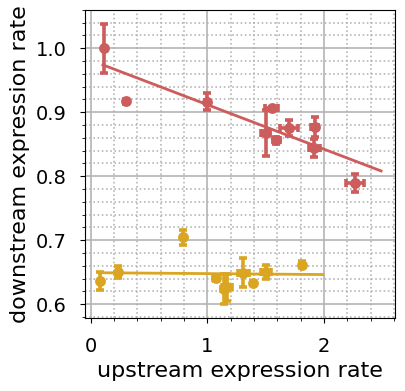

In [23]:
# Fig 1 

# This plot concerns the cancelling contextual effects by protein binding sites

fig, ax1 = plt.subplots(figsize=(OVERALL_SCALE, OVERALL_SCALE))

# Plot the Open Context data
plot_errorbar(ax1,
              x     = Data_normalized['open_test_norm']['Signal'],
              y     = Data_normalized['open_ctl_norm']['Signal'],
              xerr  = Data_normalized['open_test_norm']['Error'],
              yerr  = Data_normalized['open_ctl_norm']['Error'],
              color = 'indianred'
             )

# Fit a linear regression to the Open Context data
x_pred_o, y_pred_o = fit_linear(np.array(Data_normalized['open_test_norm']['Signal']),
                                np.array(Data_normalized['open_ctl_norm']['Signal']))
ax1.plot(x_pred_o, y_pred_o, color='indianred', linewidth=OVERALL_SCALE / 2)

# Plot the Open Context data
plot_errorbar(ax1,
              x     = Data_normalized['closed_test_norm']['Signal'],
              y     = Data_normalized['closed_ctl_norm']['Signal'],
              xerr  = Data_normalized['closed_test_norm']['Error'],
              yerr  = Data_normalized['closed_ctl_norm']['Error'],
              color = 'goldenrod'
             )

# Fit a linear regression to the Closed Context data
x_pred_c, y_pred_c = fit_linear(np.array(Data_normalized['closed_test_norm']['Signal']),
                                np.array(Data_normalized['closed_ctl_norm']['Signal']))
ax1.plot(x_pred_c, y_pred_c, color='goldenrod', linewidth=OVERALL_SCALE / 2)

# Axes' labels
ax1.set_xlabel('upstream expression rate',fontsize=OVERALL_SCALE*4)
ax1.set_ylabel('downstream expression rate',fontsize=OVERALL_SCALE*4)

# Configure appearance
configure_plot()

plt.show()

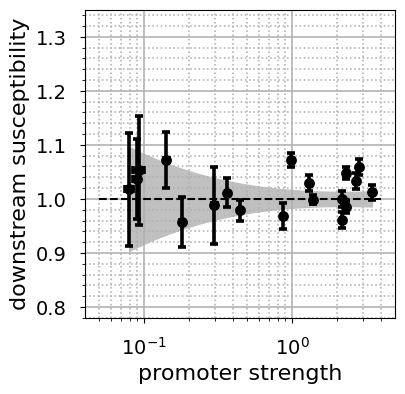

In [24]:
# Fig 2A 

# This plot concerns the susceptibility to changes in downstream distance as a function of promoter strength

fig, ax1 = plt.subplots(figsize=(OVERALL_SCALE, OVERALL_SCALE))

# Shaded regions
x = Data_filtered['downstream_short_short']['Mean'].to_numpy()
y = np.array(Data_normalized['downstream_suscep']['Error']) + 1
plot_shaded_region(ax1, x, y)

# Data points
plot_errorbar(ax1,
              Data_filtered['downstream_short_short']['Mean'],
              Data_normalized['downstream_suscep']['Signal'],
              Data_filtered['downstream_short_short']['SEM'],
              Data_normalized['downstream_suscep']['Error'],
              color='Black'
             )

# Highlightin the absissa line
ax1.hlines(1, 0.05, 4, linestyle='dashed', color='black')

# Axes' labels
ax1.set_xlabel('promoter strength',fontsize=OVERALL_SCALE*4)
ax1.set_ylabel('downstream susceptibility',fontsize=OVERALL_SCALE*4)

# Configure appearance
configure_plot(xscale='log',
               xlim=[0.05, 4],
               ylim=[0.78, 1.35])

plt.show()

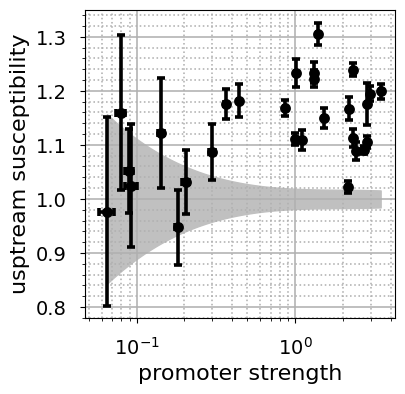

In [25]:
# Fig 2B 

# This plot concerns the susceptibility to changes in upstream distance as a function of promoter strength

fig, ax1 = plt.subplots(figsize=(OVERALL_SCALE, OVERALL_SCALE))

# Shaded regions
x = Data_filtered['upstream_short_short']['Mean'].to_numpy()
y = np.array(Data_normalized['upstream_suscep']['Error']) + 1
plot_shaded_region(ax1, x, y)

# Data points
plot_errorbar(ax1,
              Data_filtered['upstream_short_short']['Mean'],
              Data_normalized['upstream_suscep']['Signal'],
              Data_filtered['upstream_short_short']['SEM'],
              Data_normalized['upstream_suscep']['Error'],
              color='Black'
             )

# Axes' labels
ax1.set_xlabel('promoter strength',fontsize=OVERALL_SCALE*4)
ax1.set_ylabel('usptream susceptibility',fontsize=OVERALL_SCALE*4)

# Configure appearance
configure_plot(xscale='log',
               xlim=[0.05, 4],
               ylim=[0.78, 1.35])

plt.show()

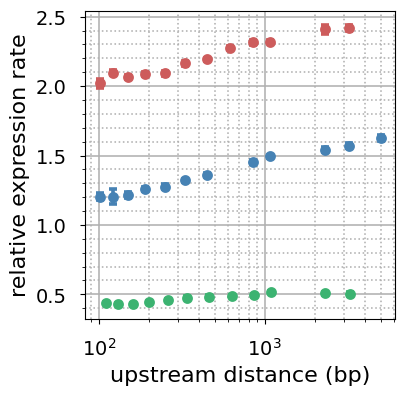

In [26]:
# Fig 3A 

# This plot concerns the scaling law between relative promoter expression rate and upstream distance

fig, ax1 = plt.subplots(figsize=(OVERALL_SCALE, OVERALL_SCALE))

# Plotting the data
plot_errorbar(ax1,
              Distances_medium,
              Data_filtered['medium']['Mean'],
              xerr=None,
              yerr=Data_filtered['medium']['SEM'],
              color='steelblue'
             )
plot_errorbar(ax1,
              Distances_weak,
              Data_filtered['weak']['Mean'],
              xerr=None,
              yerr=Data_filtered['weak']['SEM'],
              color='mediumseagreen'
             )
plot_errorbar(ax1,
              Distances_strong,
              Data_filtered['strong']['Mean'],
              xerr=None,
              yerr=Data_filtered['strong']['SEM'],
              color='indianred'
             )

# Axes' labels
ax1.set_xlabel('upstream distance (bp)',fontsize=OVERALL_SCALE*4)
ax1.set_ylabel('relative expression rate',fontsize=OVERALL_SCALE*4)

# Configure appearance
configure_plot(xscale='log')

plt.show()

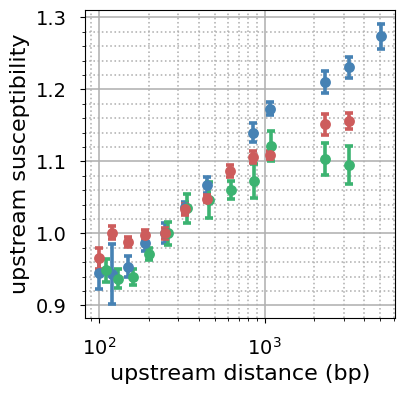

In [27]:
# Fig 3B 

# This plot concerns the scaling law between upstream susceptibility and upstream distance

fig, ax1 = plt.subplots(figsize=(OVERALL_SCALE, OVERALL_SCALE))

# Plotting the error bars
plot_errorbar(ax1,
              Distances_medium,
              Data_normalized['medium_suscep']['Signal'],
              xerr=None,
              yerr=Data_normalized['medium_suscep']['Error'],
              color='steelblue'
             )
plot_errorbar(ax1,
              Distances_weak,
              Data_normalized['weak_suscep']['Signal'],
              xerr=None,
              yerr=Data_normalized['weak_suscep']['Error'],
              color='mediumseagreen'
             )
plot_errorbar(ax1,
              Distances_strong,
              Data_normalized['strong_suscep']['Signal'],
              xerr=None,
              yerr=Data_normalized['strong_suscep']['Error'],
              color='indianred'
             )

# Axes' labels
ax1.set_xlabel('upstream distance (bp)',fontsize=OVERALL_SCALE*4)
ax1.set_ylabel('upstream susceptibility',fontsize=OVERALL_SCALE*4)

# Configure appearance
configure_plot(xscale='log')

plt.show()

## Plotting some figures from the supplementary materials

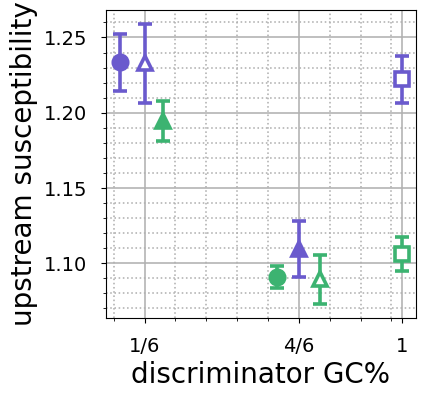

In [28]:
# Fig S2C 

# This plot concerns the relationship between upstream susceptibility and discriminator GC%

fig, ax1 = plt.subplots(figsize=(OVERALL_SCALE, OVERALL_SCALE))

# Apply shifts for the sake of plot readability 
shifts = [
    -0.08, -0.07, 0, 0, 0, +0.06, 0, +0.07    
]
xindices = []
for i in range(len(shifts)):
    xindices.append( GC[i]+shifts[i] )

# Apply different colors to different promoters
colo = ['slateblue','mediumseagreen','slateblue','slateblue',
        'slateblue','mediumseagreen','mediumseagreen','mediumseagreen']

# Define special plotting appearence
MarkerSize=2
CapSize=0.5

# Loop through all the promoters of interest
for i in range(len(Data_normalized['discriminator_suscep'])):
    
    # Store the current data
    I = Data_normalized['discriminator_suscep'].index[i]

    # Apply some special plotting appearance parameters
    plot_params = {
        'x': xindices[i],
        'y': Data_normalized['discriminator_suscep']['Signal'][i],
        'yerr': Data_normalized['discriminator_suscep']['Error'][i],
        'color': colo[i],
        'markeredgecolor':colo[i],
        'ecolor':colo[i],
        'MarkerSize': MarkerSize,
        'CapSize': CapSize,
    }

    # Define some special plotting parameters depending on the nature of the promoter
    if 'p01'in I or 'p08' in I :
        plot_errorbar(ax1,**plot_params)
    
    if 'p24' in I or 'p26' in I :           
        plot_params.update({'marker': '^'})
        plot_errorbar(ax1,**plot_params)

    if 'p25' in I or 'p28' in I:
        plot_params.update({'color':'white','marker': '^'})
        plot_errorbar(ax1,**plot_params)
        
    if 'p23' in I or 'p27' in I:
        plot_params.update({'color':'white','marker': 's'})
        plot_errorbar(ax1,**plot_params)

# Axes' labels
ax1.set_xlabel('discriminator GC%',fontsize=OVERALL_SCALE*5)
ax1.set_ylabel('upstream susceptibility',fontsize=OVERALL_SCALE*5)
        
# Configure plot appearence
configure_plot()
ax1.set_yticks([1.1, 1.15, 1.20, 1.25])
ax1.set_xticks([1/6, 4/6, 1])
ax1.set_xticklabels(['1/6','4/6','1'])

plt.show()

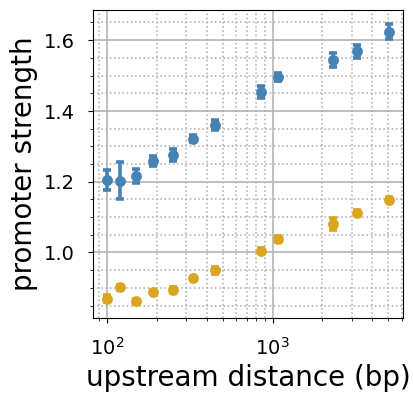

In [29]:
# Fig S3A 

# This plot concerns the relationship between promoter strength at various upstream distance and temperature

fig, ax1 = plt.subplots(figsize=(OVERALL_SCALE, OVERALL_SCALE))

# Plotting the error bars

plot_errorbar(ax1,
              Distances_medium,
              Data_filtered['t37']['Mean'],
              xerr=None,
              yerr=Data_filtered['t37']['SEM'],
              color='steelblue'
             )

plot_errorbar(ax1,
              Distances_medium,
              Data_filtered['t29']['Mean'],
              xerr=None,
              yerr=Data_filtered['t29']['SEM'],
              color='goldenrod'
             )

# Axes' labels
ax1.set_xlabel('upstream distance (bp)',fontsize=OVERALL_SCALE*5)
ax1.set_ylabel('promoter strength',fontsize=OVERALL_SCALE*5)

# Configure appearance
configure_plot(xscale='log')

plt.show()

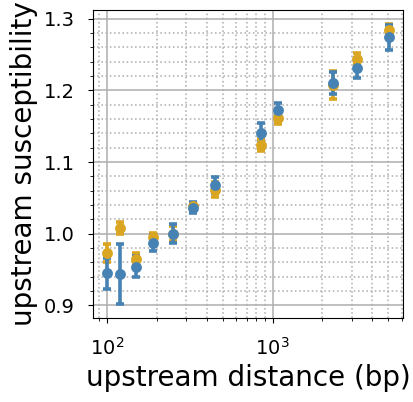

In [30]:
# Fig S3B 

# This plot concerns the relationship between susceptibility to upstream distance and temperature

fig, ax1 = plt.subplots(figsize=(OVERALL_SCALE, OVERALL_SCALE))

# Plotting the error bars

plot_errorbar(ax1,
              Distances_medium,
              Data_normalized['t29_suscep']['Signal'],
              xerr=None,
              yerr=Data_normalized['t29_suscep']['Error'],
              color='goldenrod'
             )

plot_errorbar(ax1,
              Distances_medium,
              Data_normalized['t37_suscep']['Signal'],
              xerr=None,
              yerr=Data_normalized['t37_suscep']['Error'],
              color='steelblue'
             )

# Axes' labels
ax1.set_xlabel('upstream distance (bp)',fontsize=OVERALL_SCALE*5)
ax1.set_ylabel('upstream susceptibility',fontsize=OVERALL_SCALE*5)

# Configure appearance
configure_plot(xscale='log')

plt.show()